In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("vjchoudhary7/customer-segmentation-tutorial-in-python")

print("Path to dataset files:", path)

100%|██████████| 1.55k/1.55k [00:00<?, ?B/s]

Extracting model files...
Path to dataset files: C:\Users\OMEN\.cache\kagglehub\datasets\vjchoudhary7\customer-segmentation-tutorial-in-python\versions\1


In [3]:
# Setup: libs, style, config
import os, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid", context="notebook")
plt.rcParams["figure.figsize"] = (8, 5)

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# Customized input for Mall_Customers.csv
INPUT_CSV = r"C:\Users\OMEN\.cache\kagglehub\datasets\vjchoudhary7\customer-segmentation-tutorial-in-python\versions\1\Mall_Customers.csv"  # adjust path if needed
RANDOM_STATE = 42

assert os.path.exists(INPUT_CSV), f"File not found: {INPUT_CSV}"


In [4]:
# Load Mall Customer Segmentation dataset
df = pd.read_csv(INPUT_CSV)

# Drop CustomerID if present
if "CustomerID" in df.columns:
    df = df.drop(columns=["CustomerID"])

print("Shape:", df.shape)
display(df.head(10))
print("\nData types:\n", df.dtypes)
print("\nBasic statistics:\n", df.describe())


Shape: (200, 4)


,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40
5,Female,22,17,76
6,Female,35,18,6
7,Female,23,18,94
8,Male,64,19,3
9,Female,30,19,72



Data types:
 Gender                    object
Age                        int64
Annual Income (k$)         int64
Spending Score (1-100)     int64
dtype: object

Basic statistics:
               Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000          200.000000              200.000000
mean    38.850000           60.560000               50.200000
std     13.969007           26.264721               25.823522
min     18.000000           15.000000                1.000000
25%     28.750000           41.500000               34.750000
50%     36.000000           61.500000               50.000000
75%     49.000000           78.000000               73.000000
max     70.000000          137.000000               99.000000


In [5]:
# Encode Gender if present (Male=1, Female=0) or drop it for numeric-only clustering
if "Gender" in df.columns:
    df["Gender_enc"] = df["Gender"].map({"Male": 1, "Female": 0})
    df = df.drop(columns=["Gender"])

# Select numeric features for clustering
# Common approach: use Age, Annual Income, and Spending Score
feature_cols = [c for c in ["Age", "Annual Income (k$)", "Spending Score (1-100)", "Gender_enc"] 
                if c in df.columns]
X = df[feature_cols].copy()

print("Features for clustering:", feature_cols)
print("X shape:", X.shape)


Features for clustering: ['Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'Gender_enc']
X shape: (200, 4)


In [6]:
# Standardize features (important for distance-based clustering)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Scaled features shape:", X_scaled.shape)


Scaled features shape: (200, 4)


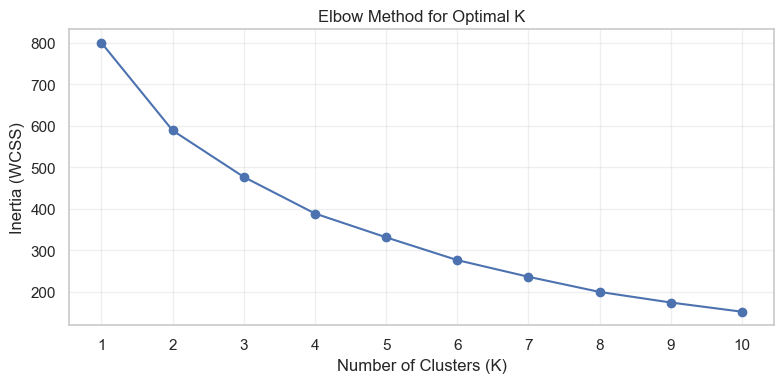

Inertia values: [799.9999999999999, 588.8026767824936, 476.7875544135159, 388.7178614053845, 331.3098837641086, 276.4117595313096, 236.2049470708688, 199.7504611206557, 174.23547730691473, 152.02983429775688]


In [7]:
# Elbow Method: compute inertia for K in range 1-10
k_range = range(1, 11)
inertias = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(8, 4))
plt.plot(list(k_range), inertias, marker="o", linestyle="-")
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia (WCSS)")
plt.xticks(list(k_range))
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("Inertia values:", inertias)


K=2: Silhouette Score = 0.2518
K=3: Silhouette Score = 0.2595
K=4: Silhouette Score = 0.2984
K=5: Silhouette Score = 0.3041
K=6: Silhouette Score = 0.3311
K=7: Silhouette Score = 0.3574
K=8: Silhouette Score = 0.3880
K=9: Silhouette Score = 0.4031
K=10: Silhouette Score = 0.4208


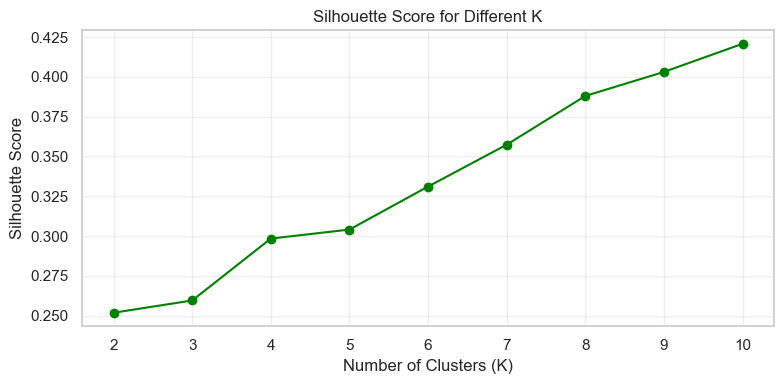


Best K by Silhouette Score: 10 (Score=0.4208)


In [8]:
# Silhouette Score for K in range 2-10 (not defined for K=1)
silhouette_scores = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)
    print(f"K={k}: Silhouette Score = {score:.4f}")

# Plot silhouette scores
plt.figure(figsize=(8, 4))
plt.plot(range(2, 11), silhouette_scores, marker="o", linestyle="-", color="green")
plt.title("Silhouette Score for Different K")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.xticks(range(2, 11))
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Best K by silhouette score
best_k_sil = range(2, 11)[int(np.argmax(silhouette_scores))]
print(f"\nBest K by Silhouette Score: {best_k_sil} (Score={max(silhouette_scores):.4f})")


In [9]:
# Choose optimal K based on elbow + silhouette (e.g., K=5 is common for this dataset)
OPTIMAL_K = 5  # adjust based on elbow/silhouette analysis above

kmeans_final = KMeans(n_clusters=OPTIMAL_K, random_state=RANDOM_STATE, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_scaled)

# Add cluster labels to original dataframe
df["Cluster"] = cluster_labels

print(f"Fitted K-Means with K={OPTIMAL_K}")
print("Cluster distribution:")
print(df["Cluster"].value_counts().sort_index())


Fitted K-Means with K=5
Cluster distribution:
Cluster
0    39
1    29
2    43
3    54
4    35
Name: count, dtype: int64


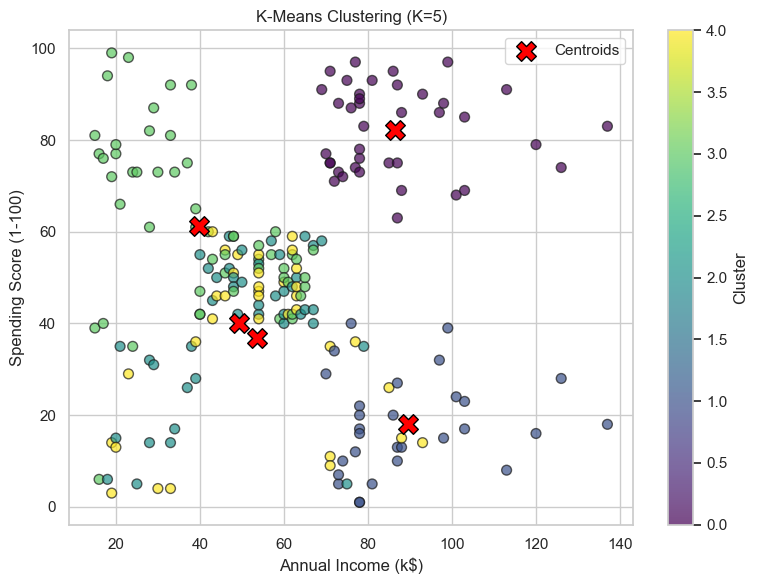

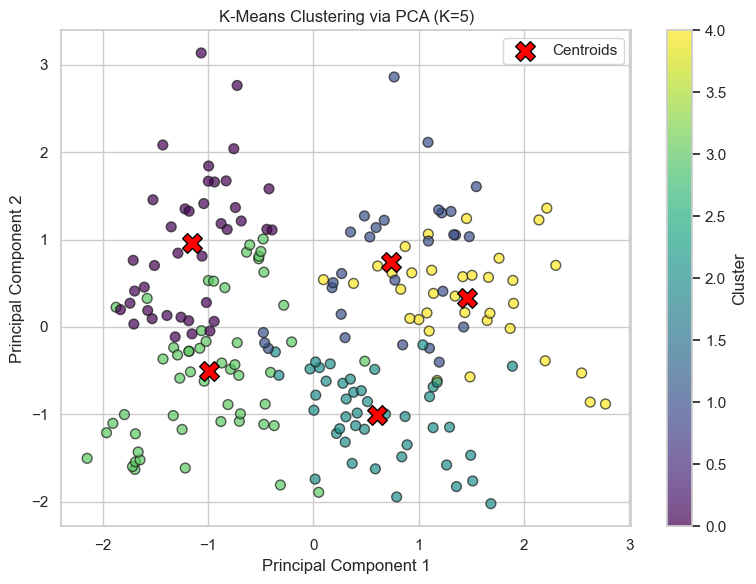

In [10]:
# Option A: 2D scatter using two key features (Annual Income vs Spending Score)
if all(c in feature_cols for c in ["Annual Income (k$)", "Spending Score (1-100)"]):
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(
        df["Annual Income (k$)"],
        df["Spending Score (1-100)"],
        c=df["Cluster"],
        cmap="viridis",
        s=50,
        edgecolor="k",
        alpha=0.7
    )
    plt.scatter(
        scaler.inverse_transform(kmeans_final.cluster_centers_)[:, feature_cols.index("Annual Income (k$)")],
        scaler.inverse_transform(kmeans_final.cluster_centers_)[:, feature_cols.index("Spending Score (1-100)")],
        c="red",
        s=200,
        marker="X",
        edgecolor="black",
        label="Centroids"
    )
    plt.title(f"K-Means Clustering (K={OPTIMAL_K})")
    plt.xlabel("Annual Income (k$)")
    plt.ylabel("Spending Score (1-100)")
    plt.colorbar(scatter, label="Cluster")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Option B: PCA to 2D for higher-dimensional feature sets
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
scatter_pca = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap="viridis", s=50, edgecolor="k", alpha=0.7)
centroids_pca = pca.transform(kmeans_final.cluster_centers_)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], c="red", s=200, marker="X", edgecolor="black", label="Centroids")
plt.title(f"K-Means Clustering via PCA (K={OPTIMAL_K})")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(scatter_pca, label="Cluster")
plt.legend()
plt.tight_layout()
plt.show()


In [11]:
# Analyze cluster characteristics
cluster_summary = df.groupby("Cluster")[feature_cols].mean()
print("\nCluster Profiles (mean values):")
display(cluster_summary)



Cluster Profiles (mean values):


,Age,Annual Income (k$),Spending Score (1-100),Gender_enc
Cluster,,,,
0,32.692308,86.538462,82.128205,0.461538
1,36.482759,89.517241,18.000000,0.448276
2,49.813953,49.232558,40.069767,0.000000
3,24.907407,39.722222,61.203704,0.407407
4,55.714286,53.685714,36.771429,1.000000
